# Module

In [1]:
import gc
import optuna
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Dataset

In [2]:
train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

print(train.shape)
train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

print(test.shape)
test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocess

In [4]:
features = [col for col in test.columns if col != 'SK_ID_CURR']
target = 'TARGET'

print(len(features))

120


In [5]:
numerical_col = [col for col in train[features].columns if train[col].dtype != 'object']
categorical_col = [col for col in train[features].columns if train[col].dtype == 'object']

In [6]:
train[numerical_col] = train[numerical_col].fillna(-999)
train[categorical_col] = train[categorical_col].fillna('missing')

print(train.isnull().sum().sum())

0


In [7]:
for i in categorical_col:
    train[i] = train[i].astype('category')

# Modeling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], random_state=666, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(246008, 120)
(246008,)
(61503, 120)
(61503,)


In [9]:
'''
def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    random_state = 666
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, y_proba)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
params = study.best_params

print(params)

'''

'\ndef create_model(trial):\n    num_leaves = trial.suggest_int("num_leaves", 2, 31)\n    n_estimators = trial.suggest_int("n_estimators", 50, 300)\n    learning_rate = trial.suggest_uniform(\'learning_rate\', 0.0001, 0.99)\n    max_depth = trial.suggest_int(\'max_depth\', 3, 8)\n    min_child_samples = trial.suggest_int(\'min_child_samples\', 100, 1200)\n    min_data_in_leaf = trial.suggest_int(\'min_data_in_leaf\', 5, 90)\n    bagging_freq = trial.suggest_int(\'bagging_freq\', 1, 7)\n    bagging_fraction = trial.suggest_uniform(\'bagging_fraction\', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform(\'feature_fraction\', 0.0001, 1.0)\n    subsample = trial.suggest_uniform(\'subsample\', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform(\'colsample_bytree\', 0.1, 1.0)\n    random_state = 666\n    \n    model = lgb.LGBMClassifier(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_rate=learning_rate,\n        max_depth=max_depth, \n     

In [10]:
params = {'num_leaves': 3,
          'n_estimators': 152,
          'learning_rate': 0.42272402391019726,
          'max_depth': 4,
          'min_child_samples': 1104,
          'min_data_in_leaf': 38,
          'bagging_freq': 2,
          'bagging_fraction': 0.9181784020694522,
          'feature_fraction': 0.2777879884871932,
          'subsample': 0.6918466190184435,
          'colsample_bytree': 0.15099510510604303}

In [11]:
%%time

cls = lgb.LGBMClassifier(**params)
cls.fit(train[features], train[target])

y_proba = cls.predict_proba(X_test)[:,1]

print('Score: ', roc_auc_score(y_test, y_proba))

[LightGBM] [Warning] bagging_fraction is set=0.9181784020694522, subsample=0.6918466190184435 will be ignored. Current value: bagging_fraction=0.9181784020694522
[LightGBM] [Warning] feature_fraction is set=0.2777879884871932, colsample_bytree=0.15099510510604303 will be ignored. Current value: feature_fraction=0.2777879884871932
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=1104 will be ignored. Current value: min_data_in_leaf=38
Score:  0.7613000487922449
CPU times: user 46 s, sys: 480 ms, total: 46.5 s
Wall time: 14.4 s


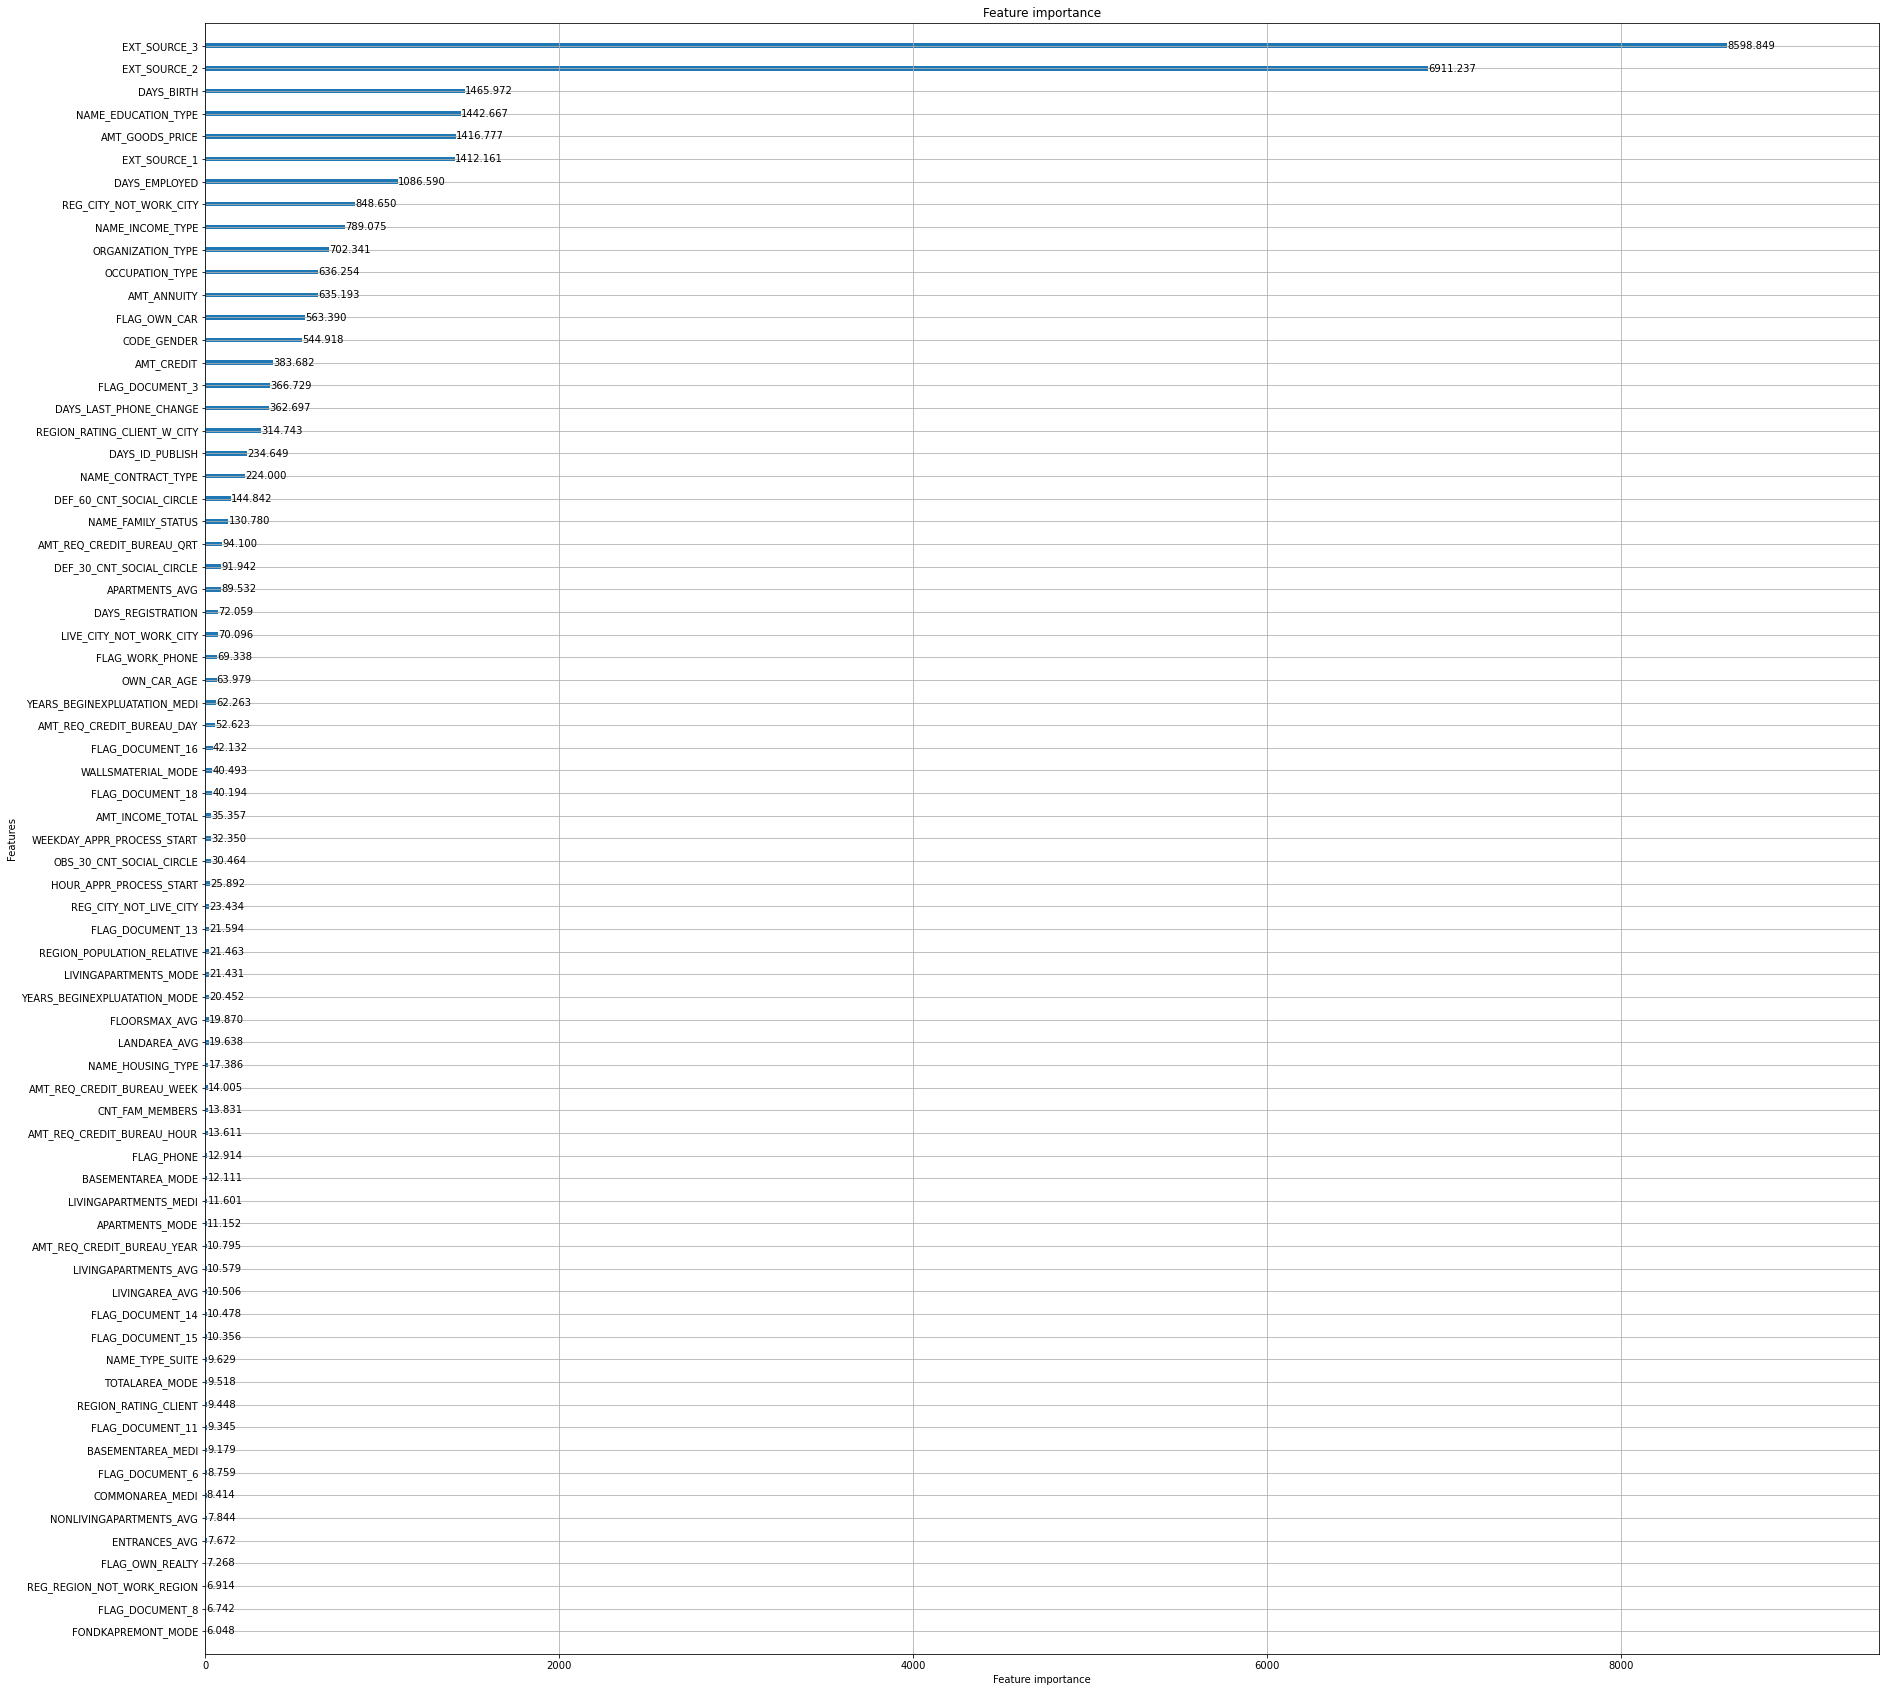

In [12]:
fig,ax = plt.subplots(figsize=(30,30))

lgb.plot_importance(cls, ax=ax,importance_type='gain',max_num_features=120)

plt.show()

# Submit

In [13]:
test[numerical_col] = test[numerical_col].fillna(-999)
test[categorical_col] = test[categorical_col].fillna('missing')

print(test.isnull().sum().sum())

0


In [14]:
for i in categorical_col:
    test[i] = test[i].astype('category')

In [15]:
y_proba = cls.predict_proba(test[features])[: , 1]

In [16]:
submit = pd.DataFrame(y_proba, index=test['SK_ID_CURR'], columns=[target])

submit.head(10)

,TARGET
SK_ID_CURR,
100001,0.054205
100005,0.123279
100013,0.037426
100028,0.045970
100038,0.135966
100042,0.041536
100057,0.014624
100065,0.059927
100066,0.017073


In [17]:
submit.to_csv('home_credit_default_risk.csv')